# Library and dataset import section: 

In [1]:
!featurize dataset download 534ff1bf-4afa-4798-b967-74b953099f65

100%|████████████████████████████████████████| 214M/214M [00:01<00:00, 158MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [2]:
from PIL import Image, ImageChops, ImageEnhance
from torchvision import transforms
import os
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import torch
import time
import torchvision.models as models

# Image pre-process section:

In [3]:
# Convert an image to ela image
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [4]:
# Resize image to fixed size
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
def prepare_image(image_path, image_size):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(convert_to_ela_image(image_path, 85).resize(image_size))

# Real image

In [6]:
# real images
X = [] # ELA converted images
Y = [] # label: 0 for fake, 1 for real

image_size = (224, 224) 
path = 'data/PSSET/real'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(1)  

print(len(X), len(Y))

960 960


# Fake image

In [7]:
# fake images

image_size = (224, 224) 
path = 'data/PSSET/fake'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(0)

print(len(X), len(Y))

1920 1920


# Shuffle and split the data

In [8]:
# Shuffle the data
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [9]:
# train, test, validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))

1382 1382
384 384
154 154


In [10]:
# Create dataloader
BATCH_SIZE = 256

train_iterator = data.DataLoader([[X_train[i], Y_train[i]] for i in range(len(Y_train))],
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader([[X_test[i], Y_test[i]] for i in range(len(Y_test))],
                                 batch_size=BATCH_SIZE)

val_iterator = data.DataLoader([[X_val[i], Y_val[i]] for i in range(len(Y_val))],
                                batch_size=BATCH_SIZE)

# VGG model

In [11]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5), 
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [12]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.LeakyReLU(inplace=True)]
            else:
                layers += [conv2d, nn.LeakyReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [13]:
# Binary classification: fake or real
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M']
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)

OUTPUT_DIM = 2
model = VGG(vgg16_layers, OUTPUT_DIM)

In [14]:
pretrained_model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/featurize/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [15]:
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

pretrained_model.classifier[-1] = final_fc

pretrained_model.features = pretrained_model.features[:24]
pretrained_model.classifier = None

print(pretrained_model.classifier)
print(pretrained_model.features)

None
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [16]:
model.load_state_dict(pretrained_model.state_dict(), strict = False)

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'], unexpected_keys=[])

In [17]:
# Learning rate
LR = 1e-3
params = [
          {'params': model.features.parameters(), 'lr': LR / 10},
          {'params': model.classifier.parameters()}
         ]
optimizer = optim.Adam(params, lr=LR, weight_decay = 0.001, amsgrad = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# Training stage

In [18]:
def calculate_accuracy_train(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [19]:
# Trains the model using backpropagation
# Input: torch.nn.Module, data.Dataloader, torch.optim.Optimizer, torch.nn.Module, torch.device
# Output: float, float
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)

        loss = criterion(y_pred, y)
        acc = calculate_accuracy_train(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
# Calculates time elapsed for the whole training
# Input: float, float
# Output: int, int
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = elapsed_time // 60
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

In [21]:
def evaluation(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            predict_real, predict_fake, tp, fp, tn, fn,acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return predict_real, predict_fake, tp, fp, tn, fn, epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy_train(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
EPOCHS = 50
best_valid_loss = float(10000)
best_epoch = -1
start_time = time.monotonic()
end_time = -1

Train_loss = []
Val_loss = []
for epoch in range(EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)


    # early stopping
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'vgg16-3layers-1st-1e-3.pt')
        end_time = time.monotonic()
        best_epoch = epoch
        best_valid_loss = valid_loss

    Train_loss.append(train_loss)
    Val_loss.append(valid_loss)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

if(end_time < 0):
  end_time = time.monotonic()
  best_epoch = EPOCHS
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 3.829 | Train Acc: 50.07%
	Val. Loss: 0.697 |  Val. Acc: 44.16%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.702 | Train Acc: 49.64%
	Val. Loss: 0.692 |  Val. Acc: 55.84%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.693 | Train Acc: 51.01%
	Val. Loss: 0.693 |  Val. Acc: 43.51%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.694 | Train Acc: 52.29%
	Val. Loss: 0.692 |  Val. Acc: 55.84%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.704 | Train Acc: 48.76%
	Val. Loss: 0.689 |  Val. Acc: 55.84%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.690 | Train Acc: 53.46%
	Val. Loss: 0.695 |  Val. Acc: 44.81%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.693 | Train Acc: 52.37%
	Val. Loss: 0.693 |  Val. Acc: 51.30%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.686 | Train Acc: 54.27%
	Val. Loss: 0.681 |  Val. Acc: 55.84%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.682 | Train Acc: 56.09%
	Val. Loss: 0.674 |  Val. Acc: 59.74%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.684 | Train Acc: 53.94%
	Val. Loss: 0.667 |  Val. Acc: 60.39%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11
	Train Loss: 0.671 | Train Acc: 57.10%
	Val. Loss: 0.670 |  Val. Acc: 56.49%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12
	Train Loss: 0.644 | Train Acc: 60.29%
	Val. Loss: 0.716 |  Val. Acc: 58.44%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13
	Train Loss: 0.658 | Train Acc: 60.26%
	Val. Loss: 0.648 |  Val. Acc: 59.74%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14
	Train Loss: 0.617 | Train Acc: 62.93%
	Val. Loss: 0.708 |  Val. Acc: 52.60%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15
	Train Loss: 0.610 | Train Acc: 64.17%
	Val. Loss: 0.637 |  Val. Acc: 57.79%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16
	Train Loss: 0.583 | Train Acc: 68.63%
	Val. Loss: 0.712 |  Val. Acc: 51.30%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17
	Train Loss: 0.570 | Train Acc: 69.64%
	Val. Loss: 0.619 |  Val. Acc: 59.74%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18
	Train Loss: 0.575 | Train Acc: 71.15%
	Val. Loss: 0.797 |  Val. Acc: 56.49%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19
	Train Loss: 0.623 | Train Acc: 62.48%
	Val. Loss: 0.630 |  Val. Acc: 61.69%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 20
	Train Loss: 0.536 | Train Acc: 72.35%
	Val. Loss: 0.676 |  Val. Acc: 65.58%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 21
	Train Loss: 0.533 | Train Acc: 73.35%
	Val. Loss: 0.616 |  Val. Acc: 69.48%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 22
	Train Loss: 0.498 | Train Acc: 74.82%
	Val. Loss: 0.608 |  Val. Acc: 69.48%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 23
	Train Loss: 0.457 | Train Acc: 78.21%
	Val. Loss: 0.634 |  Val. Acc: 64.94%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 24
	Train Loss: 0.454 | Train Acc: 78.11%
	Val. Loss: 0.614 |  Val. Acc: 64.29%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 25
	Train Loss: 0.428 | Train Acc: 78.67%
	Val. Loss: 0.709 |  Val. Acc: 62.99%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 26
	Train Loss: 0.393 | Train Acc: 80.66%
	Val. Loss: 0.914 |  Val. Acc: 59.74%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 27
	Train Loss: 0.409 | Train Acc: 80.39%
	Val. Loss: 0.647 |  Val. Acc: 68.83%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 28
	Train Loss: 0.317 | Train Acc: 86.25%
	Val. Loss: 0.660 |  Val. Acc: 64.94%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 29
	Train Loss: 0.294 | Train Acc: 86.68%
	Val. Loss: 0.660 |  Val. Acc: 70.13%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 30
	Train Loss: 0.220 | Train Acc: 91.40%
	Val. Loss: 0.768 |  Val. Acc: 64.29%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 31
	Train Loss: 0.329 | Train Acc: 85.18%
	Val. Loss: 0.901 |  Val. Acc: 61.69%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 32
	Train Loss: 0.239 | Train Acc: 89.87%
	Val. Loss: 0.912 |  Val. Acc: 64.29%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 33
	Train Loss: 0.223 | Train Acc: 90.95%
	Val. Loss: 0.999 |  Val. Acc: 65.58%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 34
	Train Loss: 0.118 | Train Acc: 96.45%
	Val. Loss: 0.734 |  Val. Acc: 72.73%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 35
	Train Loss: 0.116 | Train Acc: 95.37%
	Val. Loss: 0.853 |  Val. Acc: 70.13%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 36
	Train Loss: 0.098 | Train Acc: 96.35%
	Val. Loss: 0.798 |  Val. Acc: 66.88%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 37
	Train Loss: 0.044 | Train Acc: 98.93%
	Val. Loss: 0.828 |  Val. Acc: 69.48%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 38
	Train Loss: 0.022 | Train Acc: 99.45%
	Val. Loss: 0.957 |  Val. Acc: 71.43%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 39
	Train Loss: 0.023 | Train Acc: 99.54%
	Val. Loss: 1.114 |  Val. Acc: 68.83%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 40
	Train Loss: 0.013 | Train Acc: 99.80%
	Val. Loss: 1.062 |  Val. Acc: 68.83%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 41
	Train Loss: 0.009 | Train Acc: 99.93%
	Val. Loss: 1.013 |  Val. Acc: 70.78%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 42
	Train Loss: 0.025 | Train Acc: 99.38%
	Val. Loss: 1.733 |  Val. Acc: 62.99%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 43
	Train Loss: 0.349 | Train Acc: 86.87%
	Val. Loss: 0.791 |  Val. Acc: 69.48%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 44
	Train Loss: 0.239 | Train Acc: 88.96%
	Val. Loss: 1.028 |  Val. Acc: 62.99%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 45
	Train Loss: 0.161 | Train Acc: 93.72%
	Val. Loss: 0.909 |  Val. Acc: 68.18%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 46
	Train Loss: 0.091 | Train Acc: 96.61%
	Val. Loss: 0.959 |  Val. Acc: 64.94%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 47
	Train Loss: 0.041 | Train Acc: 98.89%
	Val. Loss: 0.878 |  Val. Acc: 73.38%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 48
	Train Loss: 0.031 | Train Acc: 99.28%
	Val. Loss: 0.906 |  Val. Acc: 68.83%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 49
	Train Loss: 0.016 | Train Acc: 99.87%
	Val. Loss: 0.959 |  Val. Acc: 68.18%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 50
	Train Loss: 0.011 | Train Acc: 99.93%
	Val. Loss: 1.031 |  Val. Acc: 70.78%


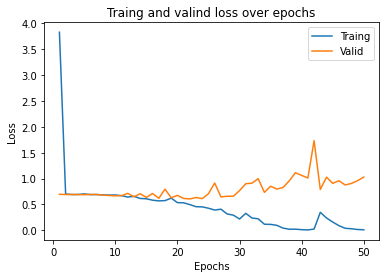

In [24]:
# LR = 1e-3
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [25]:
predict_real = 0
predict_fake = 0
tp = 0
fp = 0
tn = 0
fn = 0
epoch_loss = 0
epoch_acc = 0
model.load_state_dict(torch.load('vgg16-3layers-1st-1e-3.pt'))
            
with torch.no_grad():
    for (x, y) in tqdm(test_iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            top_pred = y_pred.argmax(1, keepdim=True)
            correct = top_pred.eq(y.view_as(top_pred)).sum()
            acc = correct.float() / y.shape[0]
            for index in range(len(y)):
                label = y[index]
                predict = top_pred[index]
                if int(predict) == 1:
                    predict_real += 1
                    if int(label) == 1:
                        tn += 1
                    if int(label) == 0:
                        fn += 1
                if int(predict) == 0:
                    predict_fake += 1
                    if int(label) == 0:
                        tp += 1
                    if int(label) == 1:
                        fp += 1

            epoch_loss += loss.item()
            epoch_acc += acc.item()


precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

test_loss = epoch_loss / len(test_iterator)
test_acc = epoch_acc / len(test_iterator)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

print('The number of predicted real images: {}'.format(predict_real))
print('The number of predicted fake images: {}'.format(predict_fake))
print('The number of correctly predicted real images: {}'.format(tn))
print('The number of correctly predicted fake images: {}'.format(tp))
print('The number of predicted fake images that should be real: {}'.format(fp))
print('The number of predicted real images that should be fake: {}'.format(fn))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('f1 score: {}'.format(f1))
print('test loss: {}'.format(test_loss))
print('test accuracy: {}'.format(test_acc))


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Lowest loss happens in epoch 22
Total Time Spent: 1.0m 57s
Test Loss: 0.624 | Test Acc: 65.04%
The number of predicted real images: 188
The number of predicted fake images: 196
The number of correctly predicted real images: 135
The number of correctly predicted fake images: 114
The number of predicted fake images that should be real: 82
The number of predicted real images that should be fake: 53
precision: 0.5816326530612245
recall: 0.6826347305389222
f1 score: 0.628099173553719
test loss: 0.6243921518325806
test accuracy: 0.650390625
